In [426]:
import numpy as np
import math
import time
import skimage.io as io
import matplotlib.pyplot as plt
import copy
from random import randint
%matplotlib inline

In [78]:
Ht, Wt = 20, 30
Ft = io.imread('smile.png')
Ft = Ft[:,:,0]

Bt = np.zeros((Ht, Wt))
for i in range(Ht):
    Bt[i,:] = randint(0,256)

In [505]:
h,w = 100, 78
X = np.load('dataSHAD300.npy')
print X.shape

(103L, 210L, 300L)


In [428]:
np.max([np.nan, 1])

nan

In [624]:
def get_lpx_d_all(X, F, B, s):
##################################################################
#
# Calculates log(p(X_k|d_k,F,B,s)) for all images X_k in X and 
# all possible displacements d_k.
#
# Input parameters:
#
#   X ... H x W x N numpy.array, N images of size H x W
#   F ... h x w numpy.array, estimate of villain's face
#   B ... H x W numpy.array, estimate of background
#   s ... 1 x 1, estimate of standart deviation of Gaussian noise
#
# Output parameters:
#   
#   lpx_d_all ... (H-h+1) x (W-w+1) x N numpy.array, 
#                 px_d_all[dh,dw,k] - log-likelihood of 
#                 observing image X_k given that the villain's 
#                 face F is located at displacement (dh, dw)
#
##################################################################
    time_start = time.time()
    h, w = F.shape
    H, W, N = X.shape
    """
    lpx = np.empty((H - h + 1, W - w + 1, N))  
    for di in range(H - h + 1):
        for dj in range(W - w + 1):
            B_with_F = copy.copy(B)
            B_with_F[di:di+h, dj:dj+w] = F
            lpx[di, dj, :] = np.sum(np.power(X - B_with_F[:,:,np.newaxis], 2), axis = (0,1))
    """
    prob_total = np.sum(np.power(X - B[:,:,np.newaxis], 2), axis = (0,1))
    lpx = np.empty((H - h + 1, W - w + 1, N))  
    prob_background_left = prob_total - np.sum(np.power(X[0:0+h, 0:0+w] - B[0:0+h, 0:0+w,np.newaxis], 2), axis = (0,1))
    for di in range(H - h + 1):
        for dj in range(W - w + 1):
            if dj == 0:
                if di != 0:
                    prob_background_left += np.sum(np.power(X[di-1:di, dj:dj+w] - B[di-1:di, dj:dj+w,np.newaxis], 2), axis = (0,1))
                    prob_background_left -= np.sum(np.power(X[di+h-1:di+h, dj:dj+w] - B[di+h-1:di+h, dj:dj+w,np.newaxis], 2), axis = (0,1))
        
                prob_background = copy.copy(prob_background_left)
            else:
                prob_background += np.sum(np.power(X[di:di+h, dj-1:dj] - B[di:di+h, dj-1:dj,np.newaxis], 2), axis = (0,1))
                prob_background -= np.sum(np.power(X[di:di+h, dj+w-1:dj+w] - B[di:di+h, dj+w-1:dj+w,np.newaxis], 2), axis = (0,1))
            lpx[di, dj, :] = prob_background + np.sum(np.power(X[di:di+h, dj:dj+w] - F[:,:,np.newaxis], 2), axis = (0,1))
    lpx = -lpx / (2. * s ** 2) - H * W * np.log(math.sqrt(2*math.pi)*s)
    print 'lpx: max={}, min={}, time={} '.format(lpx.max(), lpx.min(), time.time()-time_start)
    return lpx
            
def calc_L(X, F, B, s, A, q, useMAP = False):
###################################################################
#
# Calculates the lower bound L(q,F,B,s,A) for the marginal log 
# likelihood
#
# Input parameters:
#
#   X ... H x W x N numpy.array, N images of size H x W
#   F ... h x w numpy.array, estimate of villain's face
#   B ... H x W numpy.array, estimate of background
#   s ... 1 x 1, estimate of standart deviation of Gaussian noise
#   A ... (H-h+1) x (W-w+1) numpy.array, estimate of prior on 
#         displacement of face in any image
#   q  ... if useMAP = False:
#             (H-h+1) x (W-w+1) x N numpy.array, 
#             q[dh,dw,k] - estimate of posterior of displacement 
#             (dh,dw) of villain's face given image Xk
#           if useMAP = True:
#             2 x N numpy.array, 
#             q[1,k] - MAP estimates of dh for X_k 
#             q[2,k] - MAP estimates of dw for X_k 
#   useMAP ... logical, if true then q is a MAP estimates of 
#              displacement (dh,dw) of villain's face given image 
#              Xk 
#
# Output parameters:
#   
#   L ... 1 x 1, the lower bound L(q,F,B,s,A) for the marginal log 
#         likelihood
#
###################################################################
    time_start = time.time()
    lpx_d = get_lpx_d_all(X, F, B, s)
    if useMAP:
        ll = np.sum(lpx_d[ind] + np.nan_to_num(np.log(A))[ind[0:2]] for ind in zip(q[0], q[1], range(len(q[0]))))           
    else:
        ll = np.sum((lpx_d + np.nan_to_num(np.log(A))[:,:,np.newaxis] - np.nan_to_num(np.log(q))) * q)
    print 'll={}, time={} '.format(ll, time.time()-time_start)
    return ll

def e_step(X, F, B, s, A, useMAP = False):
##################################################################
#
# Given the current esitmate of the parameters, for each image Xk
# esitmates the probability p(d_k|X_k,F,B,s,A)
#
# Input parameters:
#
#   X ... H x W x N numpy.array, N images of size H x W
#   F ... h x w numpy.array, estimate of villain's face
#   B ... H x W numpy.array, estimate of background
#   s ... 1 x 1, estimate of standart deviation of Gaussian noise
#   A ... (H-h+1) x (W-w+1) numpy.array, estimate of prior on 
#         displacement of face in any image
#   useMAP ... logical, if true then q is a MAP estimates of 
#              displacement (dh,dw) of villain's face given image 
#              Xk 
#
# Output parameters:
#   
#   q  ... if useMAP = False:
#             (H-h+1) x (W-w+1) x N numpy.array, 
#             q[dh,dw,k] - estimate of posterior of displacement 
#             (dh,dw) of villain's face given image Xk
#           if useMAP = True:
#             2 x N numpy.array, 
#             q[1,k] - MAP estimates of dh for X_k 
#             q[2,k] - MAP estimates of dw for X_k 
###################################################################
    time_start = time.time()
    
    lpx_d = get_lpx_d_all(X, F, B, s)
    alpha = lpx_d + np.log(A)[:,:,np.newaxis]
    
    if useMAP:
        return np.array(zip(*[np.unravel_index(np.argmax(alpha[:,:,k]), (alpha.shape[0], alpha.shape[1])) for k in range(alpha.shape[2])]))
    
    alpha_max = np.nanmax(alpha, axis=(0,1))
    q = np.nan_to_num(np.exp(alpha - alpha_max))
    q /= np.sum(q, axis=(0,1))
    
    print 'E_STEP q: max={}, min={}, time={} '.format(q.max(), q.min(), time.time()-time_start)
    return q

def m_step(X, q, h, w, useMAP = False):
###################################################################
# 
# Estimates F,B,s,A given esitmate of posteriors defined by q
#
# Input parameters:
#
#   X     ... H x W x N numpy.array, N images of size H x W
#   q  ... if useMAP = False:
#             (H-h+1) x (W-w+1) x N numpy.array, 
#             q[dh,dw,k] - estimate of posterior of displacement 
#             (dh,dw) of villain's face given image Xk
#           if useMAP = True:
#             2 x N numpy.array, 
#             q[1,k] - MAP estimates of dh for X_k 
#             q[2,k] - MAP estimates of dw for X_k 
#   h ... 1 x 1, face mask hight
#   w ... 1 x 1, face mask widht
#  useMAP ... logical, if true then q is a MAP estimates of 
#             displacement (dh,dw) of villain's face given image 
#             Xk 
#
# Output parameters:
#   
#   F ... h x w numpy.array, estimate of villain's face
#   B ... H x W numpy.array, estimate of background
#   s ... 1 x 1, estimate of standart deviation of Gaussian noise
#   A ... (H-h+1) x (W-w+1) numpy.array, estimate of prior on 
#         displacement of face in any image
###################################################################
    time_start = time.time()
    H, W, N = X.shape
    if useMAP:
        A = np.zeros((H-h+1, W-w+1))
        for ind in zip(q[0], q[1]):
            A[ind] +=1
    else:
        A = q.sum(axis=2)
    A /= A.sum()
    print 'M_STEP: A={}, {}, time={}'.format(A.min(), A.max(), time.time()-time_start)
    time_start = time.time()
                                                                          
    F = np.zeros((h, w))
    if useMAP:
        for ind in zip(q[0], q[1], range(len(q[0]))):
            F += X[ind[0]:ind[0]+h, ind[1]:ind[1]+w, ind[2]]         
    else:
        for di in range(H - h + 1):
            for dj in range(W - w + 1):
                F += np.sum(q[di, dj] * X[di:di+h, dj:dj+w], axis=2)
    F /= N
    print 'M_STEP: F={}, {}, time={}'.format(F.min(), F.max(), time.time()-time_start)
    time_start = time.time()
    
    B = np.zeros((H, W))
    if useMAP:
        Q = np.zeros((H, W))
        for ind in zip(q[0], q[1], range(len(q[0]))):
            mask = np.ones((H, W),dtype=bool) #np.ones_like(a,dtype=bool)
            mask[ind[0]:ind[0]+h, ind[1]:ind[1]+w] = False
            B[mask] += X[mask, ind[2]]
            Q[mask] += 1
        B /= Q
    else:
        for i in range(H):
            for j in range(W):
                mask = np.ones((H - h + 1, W - w + 1),dtype=bool) #np.ones_like(a,dtype=bool)
                mask[max(0, i-h+1):i+1, max(0, j-w+1):j+1] = False
                B[i, j]  = np.sum(q[mask].sum(axis=0) * X[i, j, :])
                B[i, j] /= np.sum(q[mask])
    print 'M_STEP: B={}, {}, time={}'.format(B.min(), B.max(), time.time()-time_start)
    time_start = time.time()
    """
    R = 0
    
    for di in range(H - h + 1):
        for dj in range(W - w + 1):
            B_with_F = copy.copy(B)
            B_with_F[di:di+h, dj:dj+w] = F
            R += np.sum(q[di, dj,:] * (np.sum(np.power(X - B_with_F[:,:,np.newaxis], 2), axis = (0,1))))
    """
    R = 0
    if useMAP:
        for ind in zip(q[0], q[1], range(len(q[0]))):
            B_with_F = copy.copy(B)
            B_with_F[ind[0]:ind[0]+h, ind[1]:ind[1]+w] = F
            R += np.sum(np.power(X[:,:,ind[2]] - B_with_F, 2))
    else:
        prob_total = np.sum(np.power(X - B[:,:,np.newaxis], 2), axis = (0,1))
        lpx = np.empty((H - h + 1, W - w + 1, N))  
        prob_background_left = prob_total - np.sum(np.power(X[0:0+h, 0:0+w] - B[0:0+h, 0:0+w,np.newaxis], 2), axis = (0,1))
        for di in range(H - h + 1):
            for dj in range(W - w + 1):
                if dj == 0:
                    if di != 0:
                        prob_background_left += np.sum(np.power(X[di-1:di, dj:dj+w] - B[di-1:di, dj:dj+w,np.newaxis], 2), axis = (0,1))
                        prob_background_left -= np.sum(np.power(X[di+h-1:di+h, dj:dj+w] - B[di+h-1:di+h, dj:dj+w,np.newaxis], 2), axis = (0,1))

                    prob_background = copy.copy(prob_background_left)
                else:
                    prob_background += np.sum(np.power(X[di:di+h, dj-1:dj] - B[di:di+h, dj-1:dj,np.newaxis], 2), axis = (0,1))
                    prob_background -= np.sum(np.power(X[di:di+h, dj+w-1:dj+w] - B[di:di+h, dj+w-1:dj+w,np.newaxis], 2), axis = (0,1))
                R += np.sum(q[di, dj,:] * (prob_background + np.sum(np.power(X[di:di+h, dj:dj+w] - F[:,:,np.newaxis], 2), axis = (0,1))))
    s = math.sqrt(R / (H * W * N))
    print 'M_STEP: s={}, time={}'.format(s, time.time()-time_start)    
    return (F, B, s, A)
    
def run_EM(X, h, w, F=None, B = None, s = None, A = None,
    tolerance = 0.001, max_iter = 50, useMAP = False):
###################################################################
# 
# Runs EM loop until the likelihood of observing X given current
# estimate of parameters is idempotent as defined by a fixed 
# tolerance
#
# Input parameters:
#
#   X ... H x W x N numpy.array, N images of size H x W
#   h ... 1 x 1, face mask hight
#   w ... 1 x 1, face mask widht
#   F, B, s, A ... initial parameters (optional!)
#   F ... h x w numpy.array, estimate of villain's face
#   B ... H x W numpy.array, estimate of background
#   s ... 1 x 1, estimate of standart deviation of Gaussian noise
#   A ... (H-h+1) x (W-w+1) numpy.array, estimate of prior on 
#         displacement of face in any image
#   tolerance ... parameter for stopping criterion
#   max_iter  ... maximum number of iterations
#   useMAP ... logical, if true then after E-step we take only 
#              MAP estimates of displacement (dh,dw) of villain's 
#              face given image Xk 
#    
#
# Output parameters:
#   
#   F, B, s, A ... trained parameters
#   LL ... 1 x (number_of_iters + 2) numpy.array, L(q,F,B,s,A) 
#          at initial guess, after each EM iteration and after 
#          final estimate of posteriors;
#          number_of_iters is actual number of iterations that was 
#          done
###################################################################
    H, W, N = X.shape
    
    x_avg = np.average(X, axis=2)
    x_std = np.average(np.std(X, axis=2))
    if F == None:
        F = np.random.normal(np.average(x_avg), x_std, (h,w))
    if B == None:
        B = np.random.normal(x_avg, x_std)
    if s == None:
        s = x_std * 2 * np.random.rand(1)
    if A == None:
        A = np.ones((H-h+1, W-w+1)) / ((H-h+1.) * (W-w+1.))
        #A = np.random.rand(H-h+1, W-w+1)
        #A /= np.sum(A)
    iteration = 0
    LL = []
    while iteration < max_iter:
        iteration += 1
        print '******************'
        print 'iteration ',iteration
        print '******************'
        q = e_step(X, F, B, s, A, useMAP)
        
        F, B, s, A = m_step(X, q, h, w, useMAP)
        #if iteration % 3 == 0:
        L = calc_L(X, F, B, s, A, q, useMAP)        
        LL.append(L)
        if math.isnan(L):
            break
        if len(LL)>=2 and LL[-1] - LL[-2] < tolerance:
            break
    return F, B, s, A, np.array(LL)

def run_EM_with_restarts(X, h, w, tolerance = 0.001, max_iter = 50,
                     useMAP = False, restart=10):
###################################################################
# 
# Restarts EM several times from different random initializations 
# and stores the best estimate of the parameters as measured by 
# the L(q,F,B,s,A)
#
# Input parameters:
#
#   X ... H x W x N numpy.array, N images of size H x W
#   h ... 1 x 1, face mask hight
#   w ... 1 x 1, face mask widht
#   tolerance, max_iter, useMAP ... parameters for EM
#   restart   ... number of EM runs
#
# Output parameters:
#   
#   F ... h x w numpy.array, the best estimate of villain's face
#   B ... H x W numpy.array, the best estimate of background
#   s ... 1 x 1, the best estimate of standart deviation of 
#         Gaussian noise
#   A ... (H-h+1) x (W-w+1) numpy.array, the best estimate of 
#         prior on displacement of face in any image
#   LL ... 1 x 1, the best L(q,F,B,s,A)
###################################################################
    L_max = None
    
    H, W, N = X.shape
    
    x_avg = np.average(X, axis=2)
    x_std = np.average(np.std(X, axis=2))
    for i in range(restart):
        F = np.random.normal(np.average(x_avg), x_std, (h,w))
        B = np.random.normal(x_avg, x_std)
        s = x_std * 2 * np.random.rand(1)
        A = np.ones((H-h+1, W-w+1)) / ((H-h+1.) * (W-w+1.))
        F_res, B_res, s_res, A_res, LL_res = run_EM(X, h, w, F, B, s, A, tolerance, max_iter, useMAP)
        if L_max == None or LL_res[-1] > L_max:
            L_max = LL_res[-1]
            F_best, B_best, s_best, A_best = F_res, B_res, s_res, A_res
    return F_best, B_best, s_best, A_best, L_max


In [640]:
Ftt, Btt, stt, Att, LLstt = run_EM_with_restarts(Xt, ht, wt, max_iter = 50,restart=3, useMAP = True)

******************
iteration  1
******************
lpx: max=-8349.79765074, min=-10939.2268748, time=0.484999895096 
M_STEP: A=0.0, 0.075, time=0.0
M_STEP: F=50.5355626882, 261.673088392, time=0.0019998550415
M_STEP: B=-10.2356997277, 287.669581874, time=0.010999917984
M_STEP: s=207.409771446, time=0.0190000534058
lpx: max=-4014.81024113, min=-4112.78015562, time=0.511000156403 

C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:283: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:285: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:287: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:289: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:87: RuntimeWarning: divide by zero encountered in log



ll=-811201.770021, time=0.526000022888 
******************
iteration  2
******************
lpx: max=-4014.81024113, min=-4112.78015562, time=0.590000152588 
M_STEP: A=0.0, 0.095, time=0.0
M_STEP: F=39.7312383584, 277.453974038, time=0.000999927520752
M_STEP: B=-27.0119926097, 320.187020733, time=0.0090000629425
M_STEP: s=205.525121402, time=0.0199999809265
lpx: max=-4009.74183614, min=-4117.13480092, time=0.52999997139 
ll=-810077.118867, time=0.548000097275 
******************
iteration  3
******************
lpx: max=-4009.74183614, min=-4117.13480092, time=0.5 
M_STEP: A=0.0, 0.075, time=0.0
M_STEP: F=3.6197368466, 272.021137142, time=0.0119998455048
M_STEP: B=-118.214792539, 442.685137193, time=0.00699996948242
M_STEP: s=202.563660667, time=0.0140001773834
lpx: max=-4001.56004742, min=-4136.10101746, time=0.502999782562 
ll=-808329.043019, time=0.515999794006 
******************
iteration  4
******************
lpx: max=-4001.56004742, min=-4136.10101746, time=0.589000225067 
M_STEP

C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:125: RuntimeWarning: divide by zero encountered in log
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:199: RuntimeWarning: invalid value encountered in divide
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:33: RuntimeWarning: invalid value encountered in power
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: invalid value encountered in power
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:45: RuntimeWarning: invalid value encountered in power



M_STEP: A=0.0, 0.085, time=0.000999927520752
M_STEP: F=-14.9532283266, 284.031404566, time=0.00200009346008
M_STEP: B=nan, nan, time=0.0090000629425
M_STEP: s=202.663482996, time=0.0179998874664
lpx: max=nan, min=nan, time=0.526000022888 
ll=nan, time=0.542000055313 
******************
iteration  1
******************
lpx: max=-16823.6515404, min=-23379.4714661, time=0.486000061035 
M_STEP: A=0.0, 0.075, time=0.0
M_STEP: F=35.6666583341, 257.880331627, time=0.0139999389648
M_STEP: B=-43.6551679308, 376.078814685, time=0.0090000629425
M_STEP: s=206.982413335, time=0.0179998874664
lpx: max=-4010.43403141, min=-4116.50725762, time=0.508000135422 
ll=-810981.313665, time=0.523000001907 
******************
iteration  2
******************
lpx: max=-4010.43403141, min=-4116.50725762, time=0.5 
M_STEP: A=0.0, 0.085, time=0.0
M_STEP: F=6.53550489543, 276.168378221, time=0.0140001773834
M_STEP: B=-33.6240126246, 391.955633483, time=0.00799989700317
M_STEP: s=204.757323943, time=0.0130000114441
l

-807325.715869


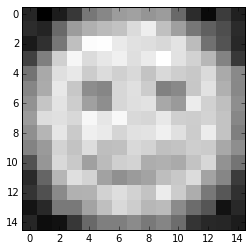

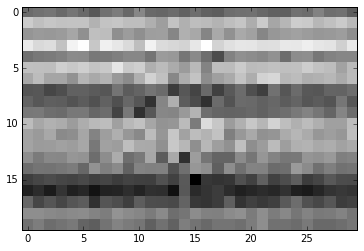

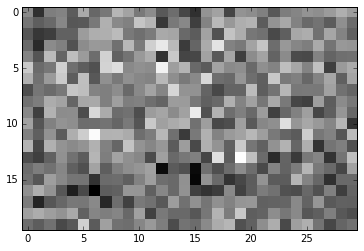

In [641]:
print LLstt
plt.imshow(Ftt, 'gray', interpolation="nearest")
plt.show()
plt.imshow(Btt, 'gray', interpolation="nearest")
plt.show()
plt.imshow(Xt[:,:,0], 'gray', interpolation="nearest")
plt.show()

In [633]:
Nt = 200
st = 200
Xt = np.zeros((Ht, Wt, Nt))
djs = []
for n in range(Nt):
    di = randint(0,Ht-ht)
    dj = randint(0,Wt-wt)
    djs.append(dj)
    noise = np.random.normal(0, st, (Ht, Wt))
    Xt[:,:,n] += Bt
    Xt[di:di+ht, dj:dj+wt, n] = Ft
    Xt[:,:,n] += noise

In [643]:
F, B, s, A, LLs = run_EM(X[:,:,0:200], h, w, max_iter = 50)

******************
iteration  1
******************
lpx: max=-359973.634376, min=-376911.239363, time=90.0959999561 
E_STEP q: max=1.0, min=0.0, time=90.1210000515 
M_STEP: A=0.0, 0.02, time=0.0
M_STEP: F=86.0076434692, 170.34785517, time=7.2619998455
M_STEP: B=68.0060566094, 186.789965649, time=7.25199985504
M_STEP: s=115.342801295, time=90.9300000668
lpx: max=-133281.989947, min=-133697.286234, time=88.8389999866 
ll=-26678771.0867, time=88.8550000191 
******************
iteration  2
******************
lpx: max=-133281.989947, min=-133697.286234, time=91.0180001259 

C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:89: RuntimeWarning: divide by zero encountered in log
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:125: RuntimeWarning: divide by zero encountered in log



E_STEP q: max=1.0, min=0.0, time=91.0260000229 
M_STEP: A=0.0, 0.0200001544597, time=0.0
M_STEP: F=89.2791448127, 170.187365371, time=7.72000002861
M_STEP: B=69.7307643782, 194.052577831, time=7.17000007629
M_STEP: s=115.281977683, time=89.6659998894
lpx: max=-133262.931622, min=-133720.974253, time=91.9680001736 
ll=-26676466.7898, time=91.9769999981 
******************
iteration  3
******************
lpx: max=-133262.931622, min=-133720.974253, time=97.1470000744 
E_STEP q: max=1.0, min=0.0, time=97.1530001163 
M_STEP: A=0.0, 0.0200199276454, time=0.0
M_STEP: F=85.3873620083, 174.156073442, time=7.98799991608
M_STEP: B=67.4753531309, 191.306118545, time=6.6779999733
M_STEP: s=115.244417575, time=88.3370001316
lpx: max=-133258.053001, min=-133737.099197, time=88.9289999008 
ll=-26675042.0533, time=88.9370000362 
******************
iteration  4
******************
lpx: max=-133258.053001, min=-133737.099197, time=91.7089998722 
E_STEP q: max=1.0, min=0.0, time=91.7179999352 
M_STEP: A=

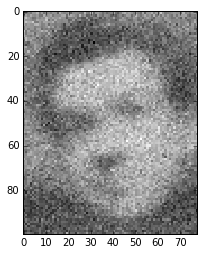

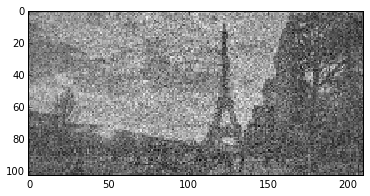

In [644]:
plt.imshow(F, 'gray', interpolation="nearest")
plt.show()
plt.imshow(B, 'gray', interpolation="nearest")
plt.show()

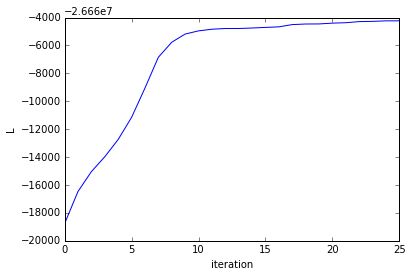

In [645]:
plt.plot(range(len(LLs)), LLs)
plt.ylabel("L")
plt.xlabel("iteration")